In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [3]:
# ------------------------
# Simulation setup
# ------------------------
np.random.seed(42)


/tmp/ipykernel_5158/1247883649.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall = df.groupby('sub').apply(fit_slope).rename('slope_all')
/tmp/ipykernel_5158/1247883649.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  by_q = df.groupby(['sub', 'questionnaire']).apply(fit_slope).reset_index(name='slope')


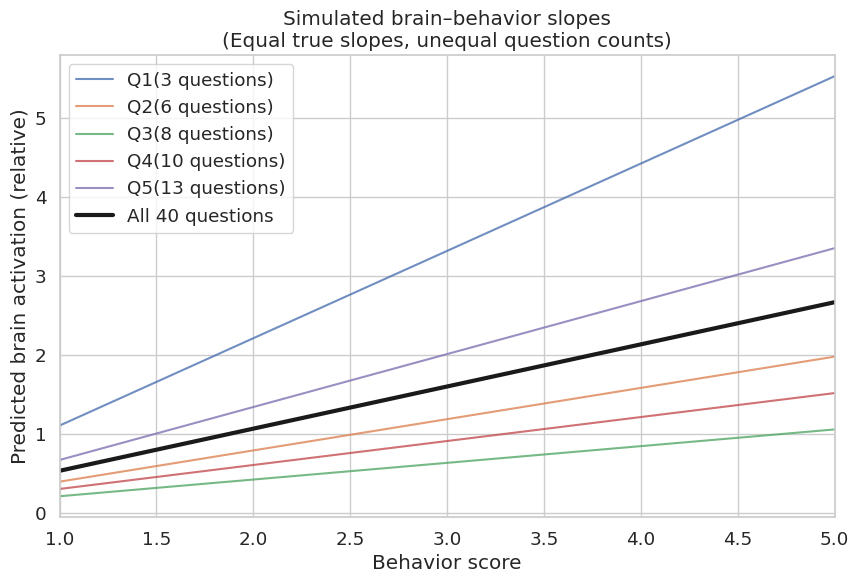

Average slopes per questionnaire and overall:
      questionnaire     slope           type
0   Q1(3 questions)  1.105253  Questionnaire
1   Q2(6 questions)  0.395558  Questionnaire
2   Q3(8 questions)  0.211343  Questionnaire
3  Q4(10 questions)  0.303355  Questionnaire
4  Q5(13 questions)  0.670085  Questionnaire
5             All40  0.533323        Overall


In [12]:
n_sub = 30
n_questions = [3, 6, 8, 10, 13]
true_slope = 0.5
within_sd = 1.0
between_sd = 1.5

# Generate data
rows = []
for sub in range(n_sub):
    subject_intercept = np.random.normal(0, between_sd)
    qid = 0
    for qi, nq in enumerate(n_questions, start=1):
        for _ in range(nq):
            behavior = np.random.randint(1, 6)  # 1–5 scale
            sub_q_int = np.random.normal(0, between_sd)
            sub_q_slope = np.random.normal(true_slope, between_sd)
            noise = np.random.normal(0, within_sd)
            brain = sub_q_int + sub_q_slope * behavior + noise
            rows.append(
                {
                    'sub': sub,
                    'questionnaire': f'Q{qi}({nq} questions)',
                    'behavior': behavior,
                    'brain': brain,
                }
            )

df = pd.DataFrame(rows)


# ------------------------
# Estimate slopes
# ------------------------
def fit_slope(data):
    X = sm.add_constant(data['behavior'])
    y = data['brain']
    model = sm.OLS(y, X).fit()
    return model.params['behavior']


# Per subject overall slope
overall = df.groupby('sub').apply(fit_slope).rename('slope_all')

# Per subject × questionnaire slopes
by_q = df.groupby(['sub', 'questionnaire']).apply(fit_slope).reset_index(name='slope')

# Merge for plotting
avg_q = by_q.groupby('questionnaire')['slope'].mean().reset_index()
avg_q['type'] = 'Questionnaire'
avg_all = pd.DataFrame(
    {'questionnaire': ['All40'], 'slope': [overall.mean()], 'type': ['Overall']}
)
plot_df = pd.concat([avg_q, avg_all], ignore_index=True)

# ------------------------
# Visualization
# ------------------------
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 6))

# Plot group-mean fitted lines
x = np.linspace(1, 5, 5)
for i, row in avg_q.iterrows():
    plt.plot(x, row['slope'] * x, label=row['questionnaire'], alpha=0.8)

# Add overall mean slope
plt.plot(x, avg_all.loc[0, 'slope'] * x, color='k', lw=3, label='All 40 questions')

plt.xlabel('Behavior score')
plt.ylabel('Predicted brain activation (relative)')
plt.title(
    'Simulated brain–behavior slopes\n(Equal true slopes, unequal question counts)'
)
plt.legend()
plt.xlim(1, 5)
plt.show()

# ------------------------
# Summary
# ------------------------
print('Average slopes per questionnaire and overall:')
print(plot_df)


/tmp/ipykernel_5158/2865250948.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall = df.groupby('sub', group_keys=False).apply(fit_slope)
/tmp/ipykernel_5158/2865250948.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_slope)
/tmp/ipykernel_5158/2865250948.py:58: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of panda

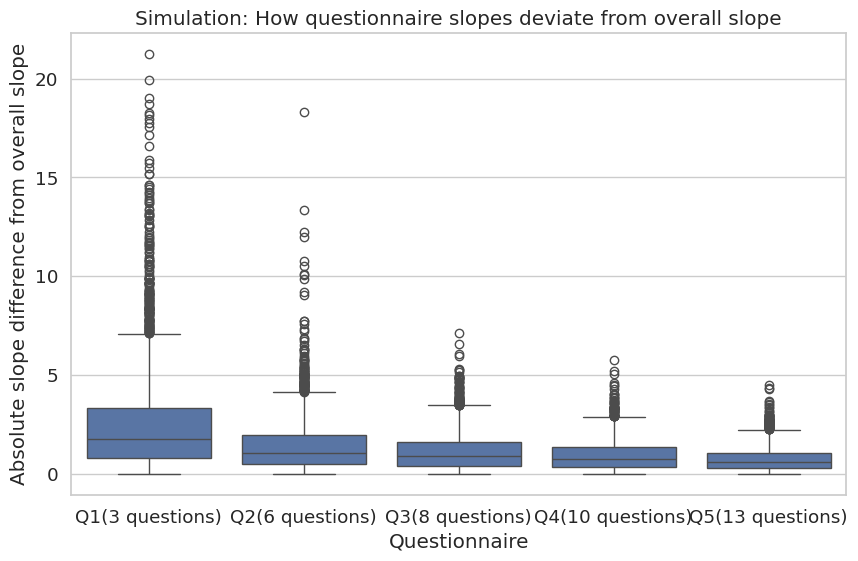

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# ------------------------
# Simulation parameters
# ------------------------
n_sim = 100
n_sub = 30
n_questions = [3, 6, 8, 10, 13]
true_slope = 0.5
within_sd = 1.0
between_sd = 1.5


# ------------------------
# Helper function to fit slope
# ------------------------
def fit_slope(data):
    X = sm.add_constant(data['behavior'])
    y = data['brain']
    model = sm.OLS(y, X).fit()
    return model.params['behavior']


# ------------------------
# Storage for all absolute differences
# ------------------------
all_diffs = []

# ------------------------
# Run simulations
# ------------------------
for sim in range(n_sim):
    # Generate data
    rows = []
    for sub in range(n_sub):
        for qi, nq in enumerate(n_questions, start=1):
            for _ in range(nq):
                behavior = np.random.randint(1, 6)  # 1–5 scale
                sub_q_int = np.random.normal(0, between_sd)
                sub_q_slope = np.random.normal(true_slope, between_sd)
                noise = np.random.normal(0, within_sd)
                brain = sub_q_int + sub_q_slope * behavior + noise
                rows.append(
                    {
                        'sub': sub,
                        'questionnaire': f'Q{qi}({nq} questions)',
                        'behavior': behavior,
                        'brain': brain,
                    }
                )
    df = pd.DataFrame(rows)

    # Overall slope per subject
    overall = df.groupby('sub', group_keys=False).apply(fit_slope)

    # Per subject × questionnaire slopes
    by_q = (
        df.groupby(['sub', 'questionnaire'], group_keys=False)
        .apply(fit_slope)
        .reset_index(name='slope')
    )

    # Compute absolute differences from overall slope
    by_q['abs_diff'] = by_q.apply(
        lambda row: abs(row['slope'] - overall[row['sub']]), axis=1
    )
    by_q['sim'] = sim  # keep track of simulation
    all_diffs.append(by_q)

# Combine all simulations
all_diffs_df = pd.concat(all_diffs, ignore_index=True)

# ------------------------
# Boxplot
# ------------------------
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 6))

# Correct order with number of questions included
order = [f'Q{i}({nq} questions)' for i, nq in enumerate(n_questions, start=1)]
sns.boxplot(data=all_diffs_df, x='questionnaire', y='abs_diff', order=order)

plt.xlabel('Questionnaire')
plt.ylabel('Absolute slope difference from overall slope')
plt.title('Simulation: How questionnaire slopes deviate from overall slope')
plt.show()


/tmp/ipykernel_175997/2974143272.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  overall = df.groupby('sub', group_keys=False).apply(fit_slope)
/tmp/ipykernel_175997/2974143272.py:65: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(fit_slope)
/tmp/ipykernel_175997/2974143272.py:60: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of

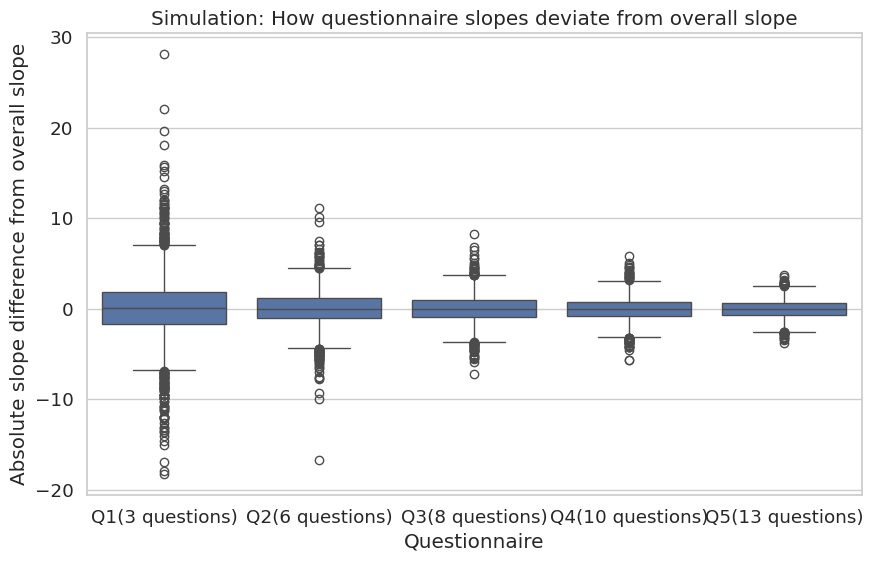

Estimated false positive rate (Q1 vs Q5): 0.040


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel

# ------------------------
# Simulation parameters
# ------------------------
n_sim = 100
n_sub = 30
n_questions = [3, 6, 8, 10, 13]
true_slope = 0.5
within_sd = 1.0
between_sd = 1.5


# ------------------------
# Helper function to fit slope
# ------------------------
def fit_slope(data):
    X = sm.add_constant(data['behavior'])
    y = data['brain']
    model = sm.OLS(y, X).fit()
    return model.params['behavior']


# ------------------------
# Storage for results
# ------------------------
all_diffs = []
p_values = []  # to store paired t-test p-values

# ------------------------
# Run simulations
# ------------------------
for sim in range(n_sim):
    # Generate data
    rows = []
    for sub in range(n_sub):
        for qi, nq in enumerate(n_questions, start=1):
            for _ in range(nq):
                behavior = np.random.randint(1, 6)  # 1–5 scale
                sub_q_int = np.random.normal(0, between_sd)
                sub_q_slope = np.random.normal(true_slope, between_sd)
                noise = np.random.normal(0, within_sd)
                brain = sub_q_int + sub_q_slope * behavior + noise
                rows.append(
                    {
                        'sub': sub,
                        'questionnaire': f'Q{qi}({nq} questions)',
                        'behavior': behavior,
                        'brain': brain,
                    }
                )
    df = pd.DataFrame(rows)

    # Overall slope per subject
    overall = df.groupby('sub', group_keys=False).apply(fit_slope)

    # Per subject × questionnaire slopes
    by_q = (
        df.groupby(['sub', 'questionnaire'], group_keys=False)
        .apply(fit_slope)
        .reset_index(name='slope')
    )

    # Compute absolute differences from overall slope
    by_q['abs_diff'] = by_q.apply(
        lambda row: (row['slope'] - overall[row['sub']]), axis=1
    )
    by_q['sim'] = sim
    all_diffs.append(by_q)

    # ------------------------
    # Paired t-test: Q1 vs Q5 slopes
    # ------------------------
    q1_slopes = by_q.loc[
        by_q['questionnaire'] == f'Q1({n_questions[0]} questions)', 'slope'
    ]
    q5_slopes = by_q.loc[
        by_q['questionnaire'] == f'Q5({n_questions[-1]} questions)', 'slope'
    ]
    if len(q1_slopes) == len(q5_slopes):  # safety check
        tstat, pval = ttest_rel(q1_slopes, q5_slopes)
        p_values.append({'sim': sim, 'pval': pval})

# Combine all results
all_diffs_df = pd.concat(all_diffs, ignore_index=True)
pval_df = pd.DataFrame(p_values)

# ------------------------
# Visualization
# ------------------------
sns.set(style='whitegrid', font_scale=1.2)
plt.figure(figsize=(10, 6))

order = [f'Q{i}({nq} questions)' for i, nq in enumerate(n_questions, start=1)]
sns.boxplot(data=all_diffs_df, x='questionnaire', y='abs_diff', order=order)

plt.xlabel('Questionnaire')
plt.ylabel('Absolute slope difference from overall slope')
plt.title('Simulation: How questionnaire slopes deviate from overall slope')
plt.show()

# ------------------------
# Check false positive rate
# ------------------------
alpha = 0.05
fp_rate = np.mean(pval_df['pval'] < alpha)
print(f'Estimated false positive rate (Q1 vs Q5): {fp_rate:.3f}')
